<a href="https://colab.research.google.com/github/luc-perso/covid-19-xRay/blob/main/leNet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'

replace /content/data_equalize/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
All
All
All
All


In [3]:
import numpy as np 
import itertools
import matplotlib.pyplot as plt
from sklearn import metrics 
import cv2
import tensorflow
import keras
from tensorflow.keras.utils import to_categorical, plot_model
from keras import Model, callbacks
from keras.layers import Input, Dense, add, Conv2D, MaxPool2D ,GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Flatten
import os

In [4]:
lungdir ='/content/data_equalize/Lung Segmentation Data'
infectdir ='/content/data_equalize/Infection Segmentation Data'

train= '/Train'
test= '/Test'
val= '/Val'

covid= '/COVID-19/images'
noncovid='/Non-COVID/images'
normal= '/Normal/images'


In [5]:
## creat data sets
IMG_SIZE= 128
def create_data() :
  data=[]
  for category in CATEGORIES :
    path = os.path.join(DIRECTORY, category)
    
    class_num = CATEGORIES.index(category)
    
    for img in os.listdir(path):
      
      img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
      new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
      data.append([new_array, class_num])
      
  return data      

  
##. Train data
DIRECTORY = lungdir+ train
CATEGORIES = ["COVID-19/images","Non-COVID/images","Normal/images"]
train_data = create_data()

X = []
y = []

for features, label in train_data :
    X.append(features)
    y.append(label)

X = np.array(X)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
X_train= X / 255

y_train = to_categorical(y)

##  Test data 
DIRECTORY = lungdir+ test
CATEGORIES = ["COVID-19/images","Non-COVID/images","Normal/images"]
test_data = create_data()

X = []
y = []

for features, label in test_data :
    X.append(features)
    y.append(label)
    
X = np.array(X)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
X_test= X / 255

y_test = to_categorical(y)


In [11]:
##.  Convolutional Neural Network with Keras
##. ##.  Resolving with the LeNet architecture

inputs = Input(shape = (128, 128,1), name = "Input")

conv_1 = Conv2D(filters = 30,                     
                kernel_size = (5, 5),            
                padding = 'valid',               
                input_shape = (128, 128, 1),       
                activation = 'relu')             

max_pool_1 = MaxPooling2D(pool_size = (2, 2))

conv_2 = Conv2D(filters = 16,                     
                kernel_size = (5, 5),            
                padding = 'valid',               
                input_shape = (128, 128, 1),       
                activation = 'relu')             

max_pool_2 = MaxPooling2D(pool_size = (2, 2))



flatten = Flatten()
dropout = Dropout(rate = 0.2)

dense_1 = Dense(units = 1024,
                activation = 'relu')

dense_2 = Dense(units = 512,
                activation = 'relu')

dense_3 = Dense(units = 3,
                activation = 'softmax')
x=conv_1(inputs)
x=max_pool_1(x)
x=conv_2(x)
x=max_pool_2(x)



x=dropout(x)
x=flatten(x)
x=dense_1(x)
x=dense_2(x)
outputs=dense_3(x)

lenet = Model(inputs = inputs, outputs = outputs)
print(lenet.summary())


plot_model(lenet)

plt.show()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 30)      780       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 30)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 16)        12016     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 16)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 29, 29, 16)        0   

In [7]:
plot_model(lenet)
fig = plt.gcf()
fig.savefig('model_lenet_128_1024_256.pdf')


<Figure size 432x288 with 0 Axes>

In [14]:
# Compilation
lenet.compile(loss='categorical_crossentropy',  
              optimizer='adam',                 
              metrics=['accuracy']) 

In [ ]:
training_history_lenet = lenet.fit(X_train, y_train,
                                   validation_split = 0.2,    
                                   epochs = 10,               
                                   batch_size = 200)          

Epoch 1/10
42/87 [=============>................] - ETA: 4:41 - loss: 1.0251 - accuracy: 0.4993

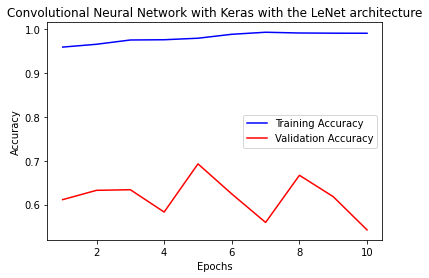

In [14]:
#
train_acc = training_history_lenet.history['accuracy']
val_acc = training_history_lenet.history['val_accuracy']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.savefig('/content/trySaving.png', bbox_inches='tight')
ax= plt.plot(np.arange(1 , 11, 1),
         training_history_lenet.history['accuracy'],
         label = 'Training Accuracy',
         color = 'blue')

ax+ plt.plot(np.arange(1 , 11, 1),
         training_history_lenet.history['val_accuracy'], 
         label = 'Validation Accuracy',
         color = 'red')

plt.title('Convolutional Neural Network with Keras with the LeNet architecture')
plt.legend()
fig = plt.gcf()
fig.savefig('fig_lenet_128_1024_256.pdf')
plt.show()



In [12]:

test_pred = lenet.predict(X_test)

# Evaluation du modèle
score = lenet.evaluate(X_test, y_test)
print(score)

test_pred_class = test_pred.argmax(axis = 1)
y_test_class = y_test.argmax(axis = 1)

print(metrics.classification_report(y_test_class, test_pred_class))

213/213 [==============================] - 49s 229ms/step


RuntimeError: ignored

[[ 338  471 1585]
 [ 744  125 1384]
 [ 728  297 1115]]


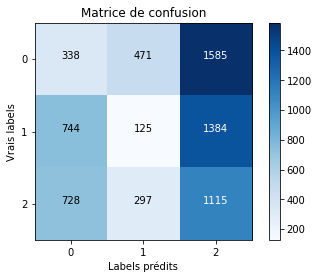

In [14]:
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
print(cnf_matrix)

classes = range(0,3)

plt.figure()

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()